In [46]:
import os
import pathlib
from collections import defaultdict

import h5py
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
import seaborn as sns
import torch
from matplotlib import rcParams
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC

plt.style.use(['science', 'no-latex'])
# rcParams['figure.figsize'] = [20, 4]
# rcParams['font.size'] = 15
# rcParams['axes.spines.top'] = False
# rcParams['axes.spines.right'] = False
# rcParams['figure.autolayout'] = True

### Data files

In [47]:
data_path = pathlib.Path("data/amygdala")
files_mat = list(data_path.rglob('*h5'))
files_mat

[WindowsPath('data/amygdala/data_NIX/Data_Subject_01_Session_01.h5'),
 WindowsPath('data/amygdala/data_NIX/Data_Subject_02_Session_01.h5'),
 WindowsPath('data/amygdala/data_NIX/Data_Subject_03_Session_01.h5'),
 WindowsPath('data/amygdala/data_NIX/Data_Subject_04_Session_01.h5'),
 WindowsPath('data/amygdala/data_NIX/Data_Subject_05_Session_01.h5'),
 WindowsPath('data/amygdala/data_NIX/Data_Subject_06_Session_01.h5'),
 WindowsPath('data/amygdala/data_NIX/Data_Subject_07_Session_01.h5'),
 WindowsPath('data/amygdala/data_NIX/Data_Subject_08_Session_01.h5'),
 WindowsPath('data/amygdala/data_NIX/Data_Subject_09_Session_01.h5')]

### Load data for one trial

In [48]:
# Open the .h5 file in read mode
with h5py.File(files_mat[0], 'r') as f:
    # Load the data
    spike_times = f['data']['Data_Subject_01_Session_01']['data_arrays'][
        'Spike_Times_Unit_1_uAL_1_Trial_01'
    ]['data']
    lfp = f['data']['Data_Subject_01_Session_01']['data_arrays']['iEEG_Data_Trial_01'][
        'data'
    ]
    waveforms = f['data']['Data_Subject_01_Session_01']['data_arrays'][
        'Spike_Waveform_Unit_1_uAL_1'
    ]['data']

    conditions = list(f['data']['Data_Subject_01_Session_01']['tags'].keys())
    labels = []
    for cond in conditions[: int(len(conditions) / 2)]:
        labels.append(cond.split('Condition_')[1].split('_Trial')[0].split('_')[1])

    # Convert the data to numpy arrays
    spike_times = np.array(spike_times)
    lfp = np.array(lfp)
    waveforms = np.array(waveforms)
    labels = np.array(labels)

### Trial time

In [49]:
fs = 2000  # Hz
time = np.arange(lfp.shape[-1]) / fs - 2
time

array([-2.    , -1.9995, -1.999 , ..., 23.9985, 23.999 , 23.9995])

### Sanity check

ISIs should be larger than 2s

In [50]:
min_isi = np.diff(spike_times).min()
min_isi

0.002437499999999204

### Plot LFP and spikes for one trial

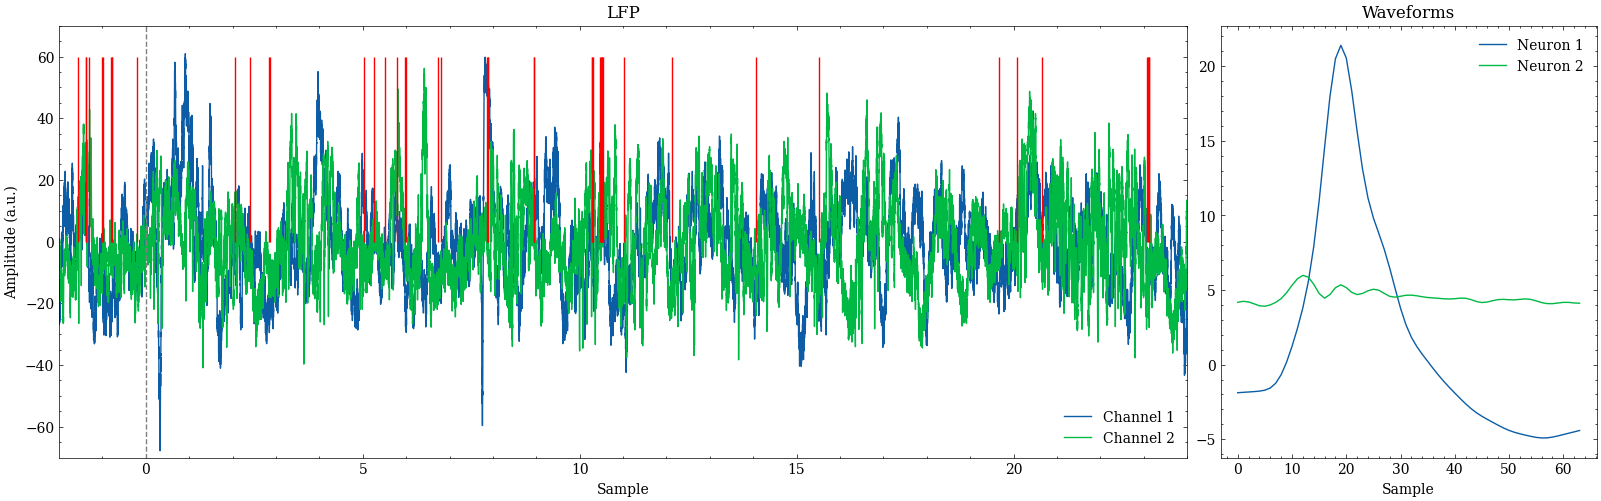

In [51]:
axs = plt.figure(figsize=(16, 5), layout="constrained").subplot_mosaic(
    [[0, 0, 0, 1]],
)

x = np.linspace(-2, 24, lfp.shape[1])
axs[0].plot(x, lfp.T, label=['Channel 1', 'Channel 2'])
axs[0].vlines(0, -80, 80, color='grey', ls='--')
axs[0].vlines(spike_times, 0, 60, color='r')
axs[1].plot(waveforms.T, label=['Neuron 1', 'Neuron 2'])

axs[0].legend(loc='lower right')
axs[1].legend()

axs[0].set_title('LFP')
axs[0].set_xlabel('Sample')
axs[0].set_ylabel('Amplitude (a.u.)')
axs[0].set_xlim([-2, 24])
axs[0].set_ylim([-70, 70])

axs[1].set_title('Waveforms')
axs[1].set_xlabel('Sample')
plt.show()

### Crop pre-spike windows

In [52]:
def to_sample_idx(t_spike, time):
    return np.argmin((t_spike - time) ** 2)


def crop_prespike_window(lfp, idx_spike, window_size, channel):
    return lfp[channel, idx_spike - window_size : idx_spike]

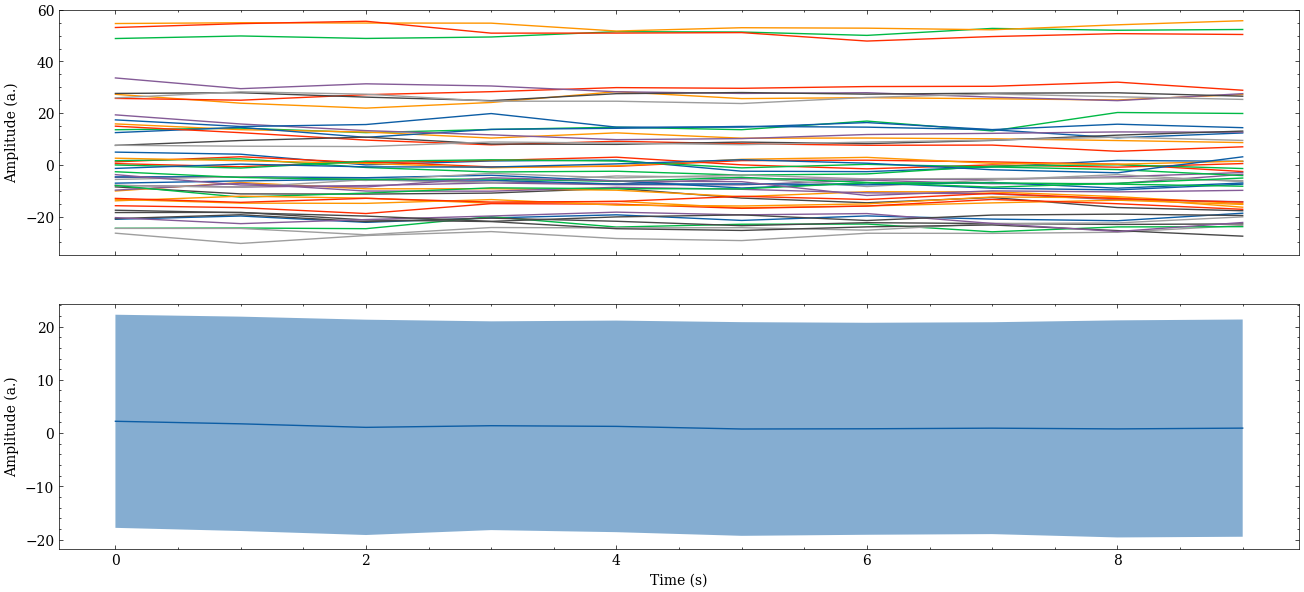

In [60]:
window_size = 10
channel_idx = 0

prespike_lfps = []
for t_spike in spike_times:
    idx_spike = to_sample_idx(t_spike, time)
    prespike_lfps.append(crop_prespike_window(lfp, idx_spike, window_size, channel_idx))
prespike_lfps = np.stack(prespike_lfps)

st_avg_lfp = prespike_lfps.mean(0)
st_var_lfp = prespike_lfps.std(0)

fig, axs = plt.subplots(2, 1, figsize=(16, 7))
axs[0].plot(prespike_lfps.T)
axs[1].plot(st_avg_lfp.T)
axs[1].fill_between(
    range(window_size), st_avg_lfp + st_var_lfp, st_avg_lfp - st_var_lfp, alpha=0.5
)
axs[0].set_ylabel('Amplitude (a.)')
axs[0].set_xticklabels([])
axs[1].set_ylabel('Amplitude (a.)')
axs[1].set_xlabel('Time (s)')
plt.show()

### Extract data for a unit

In [19]:
unit = 1
spike_times_id = f"Spike_Times_Unit_{unit}_"

spike_times_ds = []
lfp_ds = []
labels_ds = []

label_id = {'neutral': 0, 'aversive': 1}

for f_mat in files_mat:
    session = f_mat.stem
    with h5py.File(f_mat, "r") as f:
        conditions = list(f['data'][session]['tags'].keys())
        for key in f["data"][session]["data_arrays"].keys():
            # only extract spike times for a relevant unit
            if spike_times_id in key:
                # provide a key matching the trial for a relevant unit
                trial_id = key.split("_")[-1]
                trial_key = f"iEEG_Data_Trial_{trial_id}"

                # extract spike times and lfp of the current trial
                spike_times = torch.tensor(
                    np.array(f["data"][session]["data_arrays"][key]["data"])
                )
                lfp = torch.tensor(
                    np.array(f["data"][session]["data_arrays"][trial_key]["data"])
                )
                # collect spike times and lfps
                spike_times_ds.append(spike_times)
                lfp_ds.append(lfp)
                for cond in conditions[: int(len(conditions) / 2)]:
                    cond = cond.lower()
                    if trial_id in cond:
                        if 'neutral' in cond:
                            labels_ds.append(label_id['neutral'])
                        else:
                            labels_ds.append(label_id['aversive'])

In [20]:
y_control = []
X_control = defaultdict(list)
for spike_times, lfp, label in zip(spike_times_ds, lfp_ds, labels_ds):
    # handle single channels
    if lfp.dim() < 2:
        lfp = lfp.unsqueeze(0)
    random_times = torch.randint(0, lfp.shape[-1], size=(len(spike_times), 1))
    for t in random_times:
        idx_spike = to_sample_idx(t, time)
        lfp_crop = crop_prespike_window(lfp, idx_spike, window_size, channel_idx)
        if len(lfp_crop) == window_size:
            X_control["time"].append(idx_spike.item())
            X_control["lfp_crop"].append(lfp_crop)
            y_control.append(label)

X_control = torch.stack(X_control["lfp_crop"]).numpy()
y_control = np.array(y_control).reshape(-1)

### Train-test split

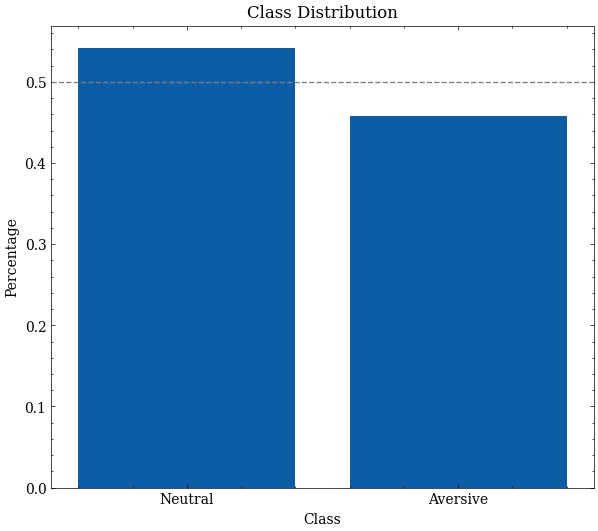

In [21]:
unique_classes, class_counts = np.unique(y_control, return_counts=True)
class_perc = class_counts / class_counts.sum()

plt.figure(figsize=(7, 6))
plt.bar(unique_classes, class_perc)
plt.hlines(0.5, -0.5, 1.5, color='grey', ls='--')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.xticks([0, 1], labels=['Neutral', 'Aversive'])
plt.xlim([-0.5, 1.5])
plt.show()

X_train, X_test, y_train, y_test = train_test_split(
    X_control, y_control, test_size=0.2, random_state=42
)

### Model training

In [22]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

### Model evaluation

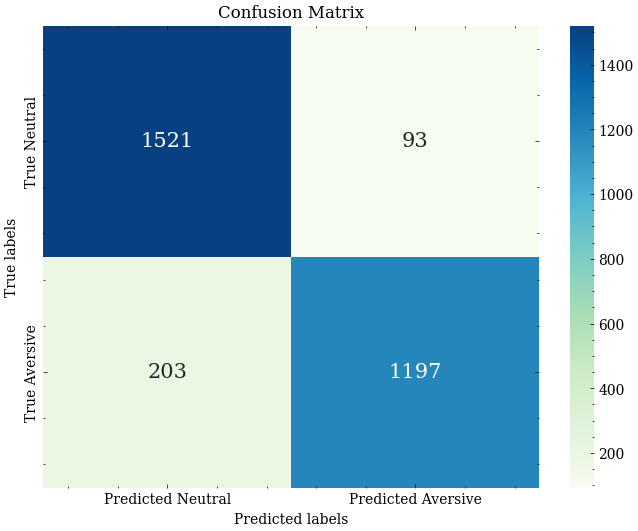

Accuracy: 0.902
Precision: 0.928
Recall: 0.855
F1-score: 0.89
Sensitivity: 0.855
Specificity: 0.942


In [44]:
def calc_metrics(cm):
    # True Positives (TP), True Negatives (TN), False Positives (FP), False Negatives (FN)
    TN, FP, FN, TP = cm.ravel()

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)

    return accuracy, precision, recall, f1, sensitivity, specificity


def calc_cm(y_test, y_pred, plot=False):
    cm = confusion_matrix(y_test, y_pred)

    if plot:
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            cm,
            annot=True,
            cmap='GnBu',
            fmt='d',
            annot_kws={"size": 15},
            xticklabels=['Predicted Neutral', 'Predicted Aversive'],
            yticklabels=['True Neutral', 'True Aversive'],
        )
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()

    return cm


cm = calc_cm(y_test, y_pred, plot=True)
accuracy, precision, recall, f1, sensitivity, specificity = calc_metrics(cm)
print(f'Accuracy: {accuracy:.3}')
print(f'Precision: {precision:.3}')
print(f'Recall: {recall:.3}')
print(f'F1-score: {f1:.3}')
print(f'Sensitivity: {sensitivity:.3}')
print(f'Specificity: {specificity:.3}')